# VB Thesis - data analysis
# Linear Regression and Machine Learning


## 1. Import Libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path

## 2. Import Data

The 'outputs' directory contains csv data of sensors saved with following attributes - 		
timestamp,room_name,internal_temp,external_temp,volume,solar_inflow		  


In [9]:
# 1️⃣ find the latest CSV in ../output
output_dir = Path('..') / 'output'
all_files = sorted(output_dir.glob('combined_training_data_*.csv'))
if not all_files:
    raise FileNotFoundError(f"No combined_training_data_*.csv found in {output_dir}")
latest_csv = all_files[-1]

# 2️⃣ read it in
df = pd.read_csv(latest_csv, parse_dates=['timestamp'])

# 3️⃣ inspect
print(f"Loaded {len(df)} rows from {latest_csv.name}")
df.head()

Loaded 3405 rows from combined_training_data_20250521.csv


,timestamp,room_name,internal_temp,external_temp,volume,solar_inflow
0,2025-03-23 12:14:39+00:00,BG.West.010,22.9,16.7,439.675687,7.998022e+06
1,2025-03-23 13:05:06+00:00,BG.West.010,23.0,16.9,439.675687,7.998022e+06
2,2025-03-23 14:05:38+00:00,BG.West.010,22.8,17.5,439.675687,7.998022e+06
3,2025-03-23 15:06:10+00:00,BG.West.010,22.9,16.6,439.675687,7.998022e+06
4,2025-03-23 16:06:42+00:00,BG.West.010,22.7,16.2,439.675687,7.998022e+06


## 3. Visualize internal_temp against external_temp and solar_inflow


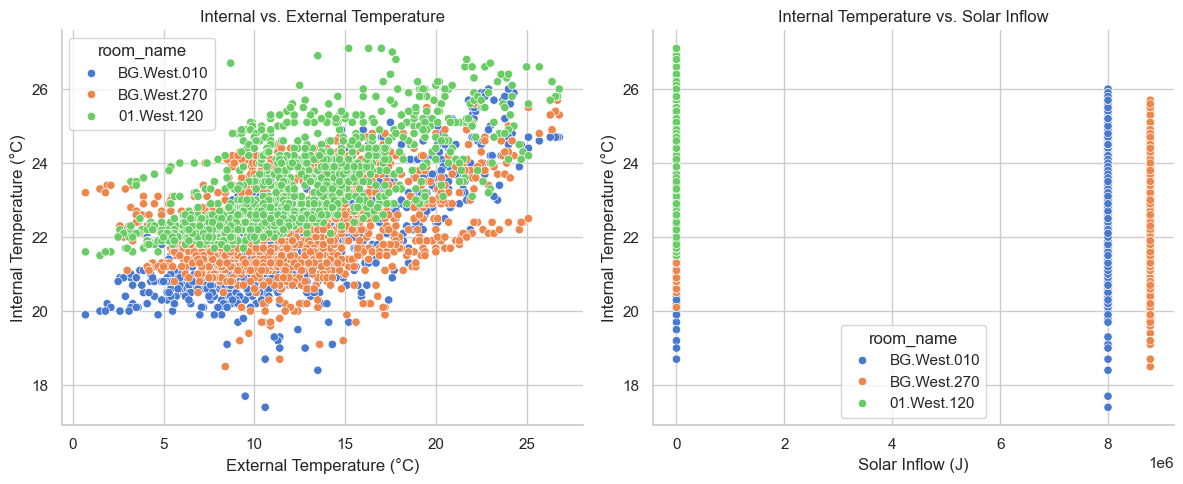

In [10]:

# Set style once
sns.set(style="whitegrid")

# Create a figure with two side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: internal vs. external temperature
sns.scatterplot(
    data=df,
    x="external_temp",
    y="internal_temp",
    hue="room_name",        # color by room if you like
    palette="muted",
    ax=axes[0]
)
axes[0].set_title("Internal vs. External Temperature")
axes[0].set_xlabel("External Temperature (°C)")
axes[0].set_ylabel("Internal Temperature (°C)")

# Plot 2: internal temperature vs. solar inflow
sns.scatterplot(
    data=df,
    x="solar_inflow",
    y="internal_temp",
    hue="room_name",
    palette="muted",
    ax=axes[1]
)
axes[1].set_title("Internal Temperature vs. Solar Inflow")
axes[1].set_xlabel("Solar Inflow (J)")
axes[1].set_ylabel("Internal Temperature (°C)")

# Tidy up
sns.despine()
plt.tight_layout()
plt.show()

### Internal vs. External Temperature

* Positive correlation: Across all rooms, higher outdoor (external) temperatures generally coincide with higher indoor (internal) temperatures.
* Room-by-room offset:
	•	BG.West.010 (blue) sits lowest—when it’s 16 °C outside, internal is around 20 °C.
	•	BG.West.270 (orange) is consistently ~2 °C warmer inside than BG.West.010 for the same outside temperature.
	•	01.West.120 (green) is warmest—about ~3–4 °C above BG.West.010 at any given external temperature.
	•	Spread: There’s some scatter (±0.5 °C) around each room’s trend, which may reflect hourly fluctuations (e.g. internal HVAC cycling, small measurement errors).

Interpretation: Each room has its own “thermal inertia” or HVAC set-point that shifts the line upward, but all rooms still track outside temperature positively.

### Internal Temperature vs. Solar 

* Solar Inflow Scale: Rooms 1 & 2 have substantial solar gains (~8×10⁶ J per timestamp). Room 3 has zero (no windows), so all its points stack at x=0
* Effect of Solar Gains:
	•	BG.West.010 (blue): As solar inflow increases from ~8.0 to ~8.2×10⁶ J, internal temperature rises from ~20.0 °C to ~23.0 °C.
	•	BG.West.270 (orange): Solar gains push internal from ~23.5 to ~24.0 °C—a smaller slope, suggesting perhaps better insulation or shading.

Interpretation: Solar inflow contributes noticeably to indoor warming in the glazed rooms (1 & 2), but the magnitude differs by room. 

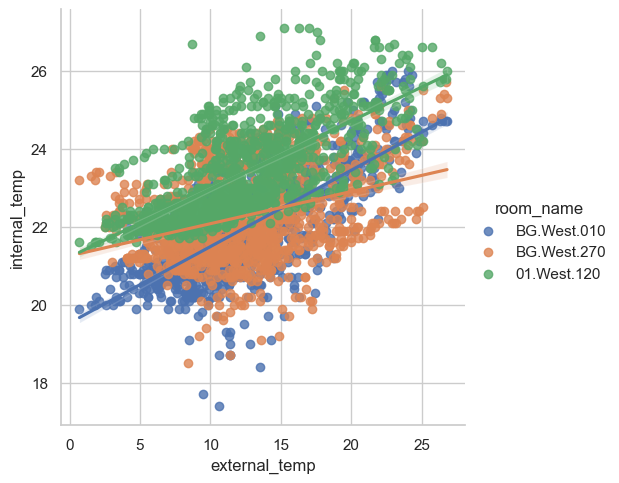

In [11]:
sns.lmplot(data=df, x="external_temp", y="internal_temp", hue="room_name")

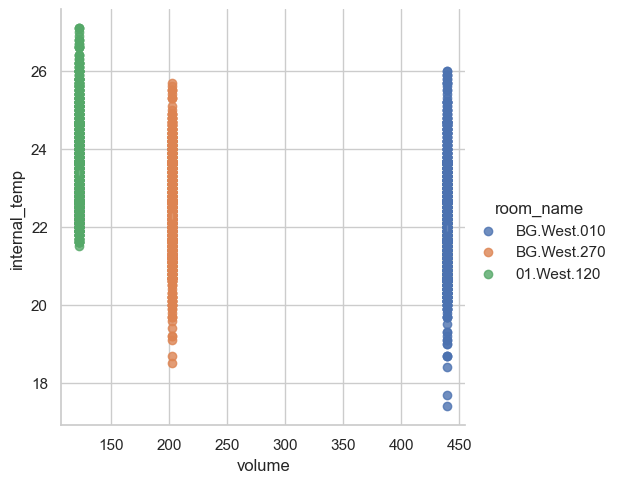

In [21]:
sns.lmplot(data=df, x="volume", y="internal_temp", hue="room_name") 

## 4. Visualize Errors

/Users/vb/Desktop/VBThesisCode2_FastAPI/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


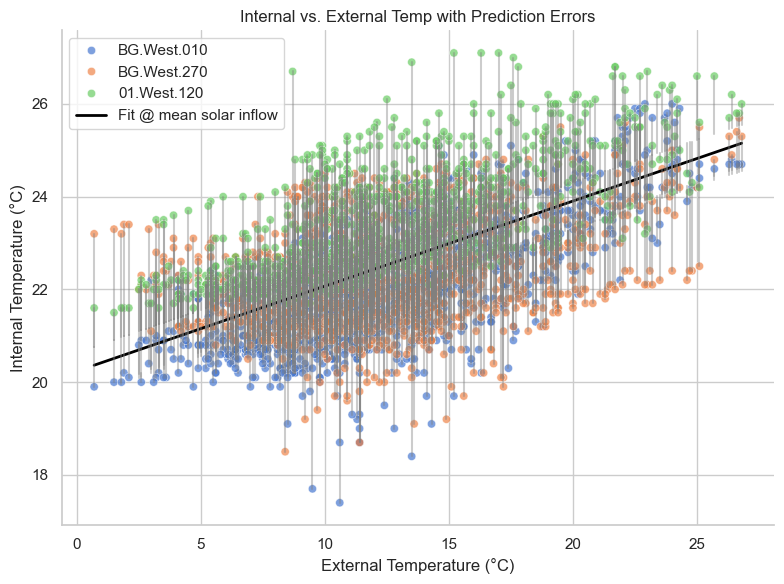

In [12]:
# Visualize prediction errors vs. External Temperature
from sklearn.linear_model import LinearRegression

# 1. Prepare data
X = df[['external_temp', 'solar_inflow']]   # your two features
y = df['internal_temp']

# 2. Fit a simple linear model
model = LinearRegression()
model.fit(X, y)
df['pred'] = model.predict(X)

# 3. Create scatter + fitted line (holding solar_inflow at its mean)
mean_solar = df['solar_inflow'].mean()
# we'll plot a line of predicted internal_temp vs. external_temp at mean solar
ext_grid = np.linspace(df['external_temp'].min(), df['external_temp'].max(), 100)
pred_line = model.predict(
    np.column_stack([ext_grid, np.full_like(ext_grid, mean_solar)])
)

# 4. Plot
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='external_temp',
    y='internal_temp',
    hue='room_name',
    palette='muted',
    alpha=0.7,
    ax=ax
)
# fitted line
sns.lineplot(
    x=ext_grid,
    y=pred_line,
    color='black',
    linewidth=2,
    label='Fit @ mean solar inflow',
    ax=ax
)

# 5. vertical error bars
for _, row in df.iterrows():
    ax.plot(
        [row['external_temp'], row['external_temp']],
        [row['internal_temp'], row['pred']],
        color='gray',
        alpha=0.4
    )

ax.set_title("Internal vs. External Temp with Prediction Errors")
ax.set_xlabel("External Temperature (°C)")
ax.set_ylabel("Internal Temperature (°C)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

## 5. Predict Temperature using Multiple Variables

Below is the analogous 3-D plot of internal_temp (target) versus external_temp and solar_inflow (features). It fits the same linear model trained above, then shows both the raw points and the model’s prediction plane.

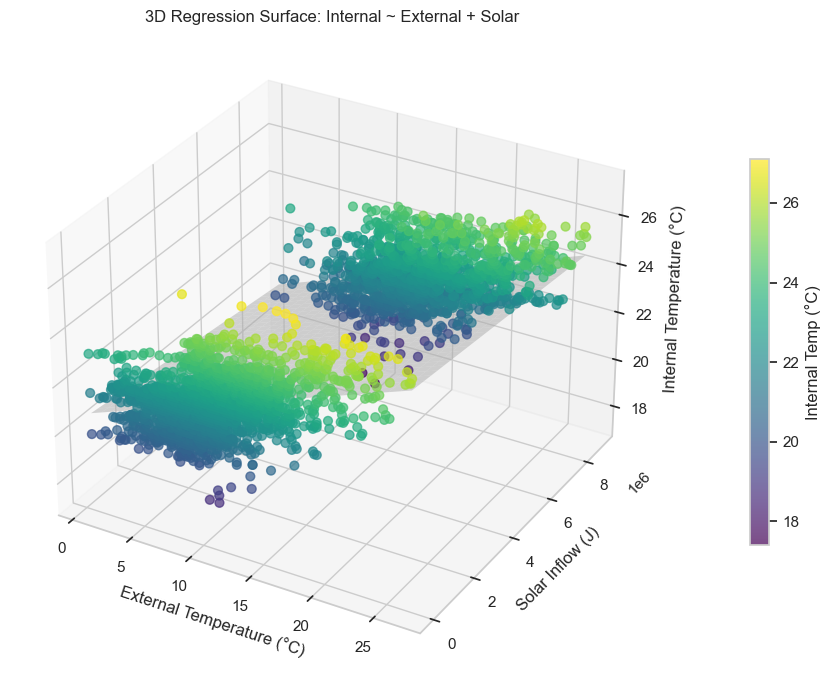

In [14]:
# 3D Visualization: internal_temp ~ external_temp + solar_inflow

from sklearn.linear_model import LinearRegression
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # you already have this import

# Prepare X and y
X = df[['external_temp', 'solar_inflow']].values
y = df['internal_temp'].values

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Build a grid to plot the prediction surface
ext_vals = np.linspace(df['external_temp'].min(), df['external_temp'].max(), 30)
solar_vals = np.linspace(df['solar_inflow'].min(), df['solar_inflow'].max(), 30)
EXT, SOLAR = np.meshgrid(ext_vals, solar_vals)
# Flatten and stack for prediction
grid_points = np.column_stack([EXT.ravel(), SOLAR.ravel()])
pred_surface = model.predict(grid_points).reshape(EXT.shape)

# Start 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter the actual data points
sc = ax.scatter(
    df['external_temp'],
    df['solar_inflow'],
    df['internal_temp'],
    c=df['internal_temp'],
    cmap='viridis',
    s=40,
    alpha=0.7
)

# Plot the prediction surface
ax.plot_surface(
    EXT, SOLAR, pred_surface,
    rstride=1,
    cstride=1,
    color='lightgrey',
    alpha=0.5,
    edgecolor='none'
)

# Labels and title
ax.set_xlabel("External Temperature (°C)")
ax.set_ylabel("Solar Inflow (J)")
ax.set_zlabel("Internal Temperature (°C)")
ax.set_title("3D Regression Surface: Internal ~ External + Solar")

# Optional colorbar
cbar = fig.colorbar(sc, pad=0.1, shrink=0.6)
cbar.set_label("Internal Temp (°C)")

plt.tight_layout()
plt.show()

## Quantification of variable changes: 
### For all three rooms together, exploring the relative impact of external_temp, solar_inflow and volume on internal_temp


	1. Standardize each feature so their regression coefficients are directly comparable (“a 1 σ change in X produces β °C change in internal_temp”).

    
	2. Fit both a statsmodels OLS (for a full summary) and a sklearn LinearRegression (for a quick coefficient lookup).

In [16]:
# Quantify relative effects via standardized regression

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 1️⃣ Choose the three predictors
features = ['external_temp', 'solar_inflow', 'volume']
target   = 'internal_temp'

# 2️⃣ Standardize features (zero mean, unit std)
df_std = df.copy()
for col in features:
    μ, σ = df[col].mean(), df[col].std()
    df_std[col + '_std'] = (df[col] - μ) / σ

# 3️⃣ statsmodels OLS on standardized features
X_sm = df_std[[f + '_std' for f in features]]
X_sm = sm.add_constant(X_sm)          # adds intercept
y_sm = df_std[target]

ols = sm.OLS(y_sm, X_sm).fit()
print(ols.summary().tables[1])        # just the coefficients table

# 4️⃣ sklearn pipeline for quick coefs
pipe = make_pipeline(
    StandardScaler(),                 # scales external_temp, solar_inflow, volume
    LinearRegression()
)
pipe.fit(df[features], df[target])
lr_coefs = pipe.named_steps['linearregression'].coef_

# 5️⃣ Display sklearn coefs in a Series
import pandas as pd
coef_df = pd.Series(lr_coefs, index=features).sort_values(key=abs, ascending=False)
print("\nStandardized Coefficients (sklearn):")
print(coef_df)

                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.5225      0.017   1305.190      0.000      22.489      22.556
external_temp_std     0.8164      0.018     44.240      0.000       0.780       0.853
solar_inflow_std     -0.3228      0.020    -16.359      0.000      -0.361      -0.284
volume_std           -0.3801      0.019    -20.419      0.000      -0.417      -0.344

Standardized Coefficients (sklearn):
external_temp    0.816288
volume          -0.380018
solar_inflow    -0.322728
dtype: float64


## Standardized Regression Results

| Predictor               | Std β    | Interpretation                                                                                           |
|-------------------------|---------:|----------------------------------------------------------------------------------------------------------|
| **const**               | 22.52    | When all predictors are at their average (0 σ), the model predicts **22.5 °C** indoor temperature.       |
| **external_temp_std**   | +0.816   | A 1 σ rise in **outside temperature** corresponds to about a **+0.82 °C** change in indoor temperature.   |
| **solar_inflow_std**    | –0.323   | A 1 σ increase in **solar gains** corresponds to about a **–0.32 °C** change in indoor temperature (holding other factors constant). |
| **volume_std**          | –0.380   | A 1 σ increase in **room volume** corresponds to about a **–0.38 °C** change in indoor temperature (larger rooms heat up less). |

**Ranked by effect size (from sklearn):**

1. **External temperature** (+0.816): strongest effect  
2. **Volume** (|–0.380|): medium effect  
3. **Solar inflow** (|–0.323|): smaller effect  

---

### Key Takeaways

- **Outside temperature** now shows the largest standardized impact—indoor temperature shifts by about 0.82 °C for each 1 σ change outdoors.  
- **Room volume** has the next biggest effect (≈ 0.38 °C per σ), indicating that larger rooms dampen temperature swings.  
- **Solar inflow** still contributes measurably (≈ 0.32 °C per σ), but less than the other two factors.  
- All predictors remain highly significant (p < 0.001).

> **Bottom line:** Controlling outdoor temperature exposure yields the biggest change in indoor conditions, though room size and solar gains also play important roles.  

## Comparing prediction - standard regression V/S XGBoost 

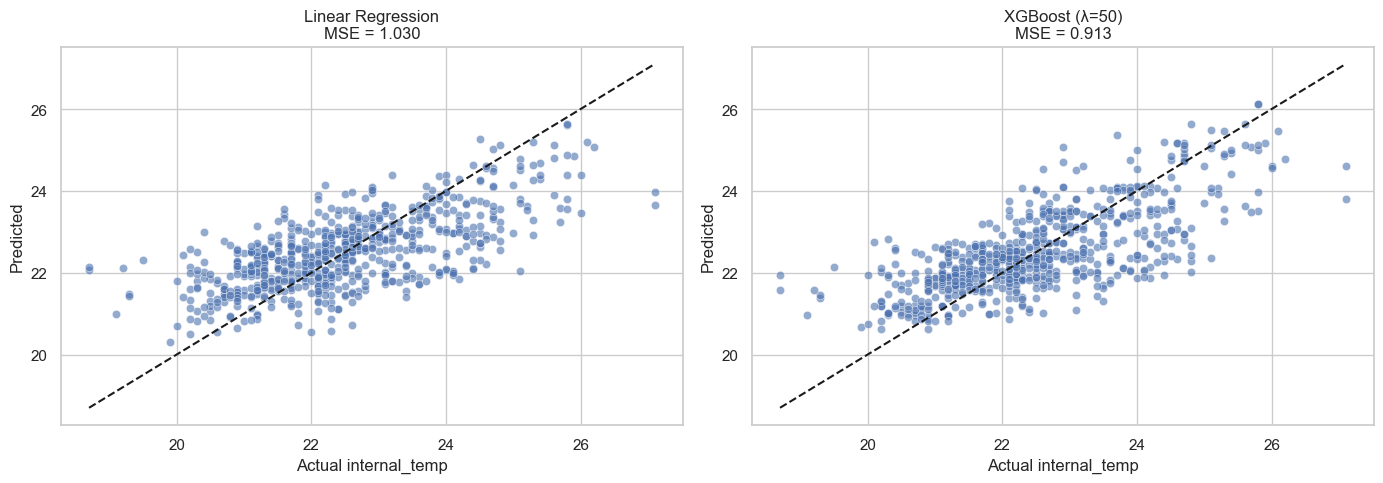

,MSE
XGB λ=50,0.913474
XGB λ=10,0.964708
LinearRegression,1.030087
XGB λ=1,1.085295
XGB λ=0,1.155024


In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 0️⃣ PrepareFeatures & target
features = ['external_temp', 'solar_inflow', 'volume']
X = df[features]
y = df['internal_temp']

# 1️⃣ train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2️⃣ Fit Linear Regression
lin = LinearRegression().fit(X_train, y_train)
y_pred_lin = lin.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)

# 3️⃣ Fit several XGBoost models with different L2 (reg_lambda)
lambdas = [0, 1, 10, 50]
xgb_results = {}
xgb_models  = {}
for lam in lambdas:
    name = f'XGB λ={lam}'
    model = XGBRegressor(
        reg_lambda=lam,
        random_state=42,
        eval_metric='rmse'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    xgb_results[name] = mean_squared_error(y_test, y_pred)
    xgb_models[name]  = model   # ← store the fitted model

# 4️⃣ Choose best XGB and get its predictions
best_name     = min(xgb_results, key=xgb_results.get)
best_model    = xgb_models[best_name]
best_pred_xgb = best_model.predict(X_test)
best_mse      = xgb_results[best_name]

# 5️⃣ Plot Actual vs. Predicted
plt.figure(figsize=(14,5))

# Linear panel
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred_lin, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--')
plt.title(f'Linear Regression\nMSE = {mse_lin:.3f}')
plt.xlabel('Actual internal_temp')
plt.ylabel('Predicted')

# XGBoost panel
plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=best_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--')
best_lambda = best_name.split('=')[1]
plt.title(f"XGBoost (λ={best_lambda})\nMSE = {best_mse:.3f}")
plt.xlabel('Actual internal_temp')
plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

# 6️⃣ Tabulate MSEs
mse_comparison = {
    'LinearRegression': mse_lin,
    **xgb_results
}
mse_df = pd.Series(mse_comparison, name='MSE').sort_values()
display(mse_df.to_frame())

Currently XGB is only slightly better than linear regression. To improve the model, there are two main methods: 
	1.	Hyperparameter tuning via cross‐validation
	2.	Early stopping on a held‐out eval set